# Lista 05 - Estrutura de Dados
##### Nome: Antonio Elimar Ximenes Oliveira
##### Matrícula: 584261

Algoritmos de Detecção de Ataques Coordenados

# Questão 1

In [2]:
import pandas as pd

### a) Ler o dataset fakeTelegram.BR_2022.csv

In [3]:
df = pd.read_csv(r'D:\10 - Materiais e Atividades disciplinas MDCC\1 - Atividades MDCC\Estrutura de Dados\fakeTelegram.BR_2022.csv')

In [4]:
# Exibe as 5 primeiras linhas
df.head()

,date_message,id_member_anonymous,id_group_anonymous,media,media_type,media_url,has_media,has_media_url,trava_zap,text_content_anonymous,dataset_info_id,date_system,score_sentiment,score_misinformation,id_message,message_type,messenger,media_name,media_md5
0,2022-10-05 06:25:04,1078cc958f0febe28f4d03207660715f,12283e08a2eb5789201e105b34489ee7,NaN,NaN,NaN,False,False,False,Então é Fato Renato o áudio que eu ouvi no wha...,5,2022-10-05 06:25:28.863641,0.0000,NaN,16385,Texto,telegram,NaN,NaN
1,2022-10-05 06:25:08,NaN,12283e08a2eb5789201e105b34489ee7,NaN,NaN,NaN,False,False,False,"Saiu no YouTube do presidente a 8 horas atrás,...",5,2022-10-05 06:25:28.926311,0.0644,NaN,16386,Texto,telegram,NaN,NaN
2,2022-10-05 06:26:28,92a2d8fd7144074f659d1d29dc3751da,9f2d7394334eb224c061c9740b5748fc,NaN,NaN,NaN,False,False,False,"É isso, nossa parte já foi quase toda feita. N...",5,2022-10-05 06:26:29.361949,-0.3551,0.157242,16366,Texto,telegram,NaN,NaN
3,2022-10-05 06:27:28,d60aa38f62b4977426b70944af4aff72,c8f2de56550ed0bf85249608b7ead93d,94dca4cda503100ebfda7ce2bcc060eb.jpg,image/jpg,NaN,True,False,False,GENTE ACHEI ELES EM UMA SEITA MAÇONÁRICA,5,2022-10-05 06:27:29.935624,0.0000,NaN,19281,Imagem,telegram,NaN,94dca4cda503100ebfda7ce2bcc060eb
4,2022-10-05 06:27:44,cd6979b0b5265f08468fa1689b6300ce,e56ec342fc599ebb4ed89655eb6f03aa,5ad5c8bbe9da93a37fecf3e5aa5b0637.jpg,image/jpg,NaN,True,False,False,NaN,5,2022-10-05 06:28:29.316325,NaN,NaN,507185,Imagem,telegram,NaN,5ad5c8bbe9da93a37fecf3e5aa5b0637


In [5]:
len(df)

557586

### b) Remova os trava-zaps.

Como temos uma coluna chamada `trava_zap`, que é do tipo booleano, vamos, a princípio, verificar a quantidaade de "trava zap" e remover essas linhas.

In [6]:
# Contar a quantidade de True e False na coluna 'trava_zap'
contagem_trava_zap = df['trava_zap'].value_counts()

# Exibir o resultado
contagem_trava_zap

trava_zap
False    557570
True         16
Name: count, dtype: int64

In [7]:
# Mantém apenas as linhas onde 'trava_zap' é False (ou seja, remove os "trava-zaps")
df = df[df['trava_zap'] == False] # Mantém apenas as linhas onde 'trava_zap' é False (ou seja, remove os "trava-zaps")
df = df[df['trava_zap'] == False]

Também vou remover aquela mensagem automática relacionada ao TSE

In [8]:
df = df[df['text_content_anonymous'] != 
    "This community was blocked in Brazil following a decision of the Superior Electoral Court (TSE)."]

### c) Remover textos com menos de 5 palavras.

In [9]:
# Verifica se é um STR (Nan são removidos) e se tem mais de 5 palavras
df = df[df['text_content_anonymous'].apply(lambda x: isinstance(x, str) and len(x.split()) >= 5)]

In [10]:
print("Quantidade restante após remoção: ", len(df))

Quantidade restante após remoção:  321864


### Explorando o Dataset

In [42]:
# Quantidade de usuários distintos
num_usuarios = df["id_member_anonymous"].nunique()
print("Quantidade de usuários distintos:", num_usuarios)

# Contagem total de mensagens
total_msgs = len(df)

# Média de mensagens por usuário
media_msgs = total_msgs / num_usuarios
print("Média de mensagens por usuário:", media_msgs)

Quantidade de usuários distintos: 10677
Média de mensagens por usuário: 30.145546501826356


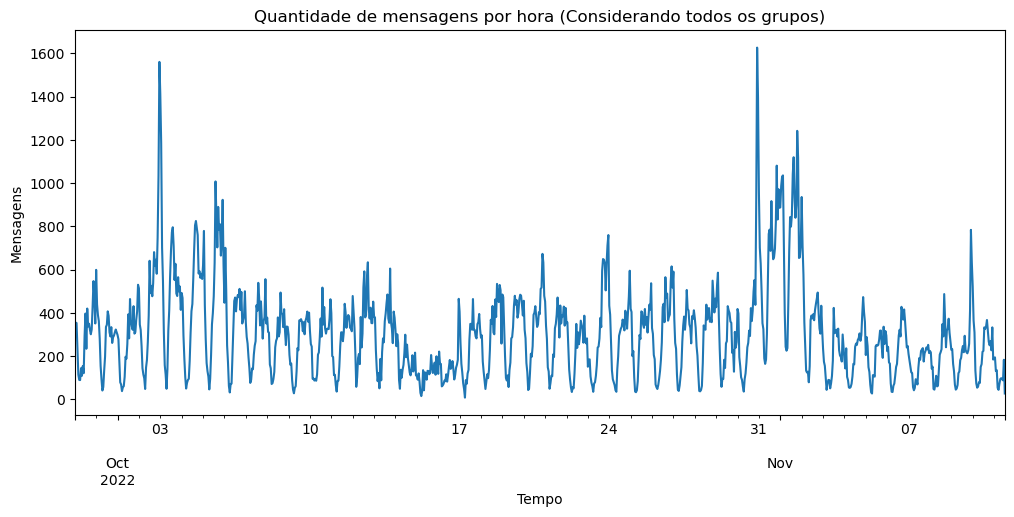

In [25]:
import matplotlib.pyplot as plt

df.set_index("date_message").resample("1h").size().plot(figsize=(12,5))
plt.title("Quantidade de mensagens por hora (Considerando todos os grupos)")
plt.ylabel("Mensagens")
plt.xlabel("Tempo")
plt.show()

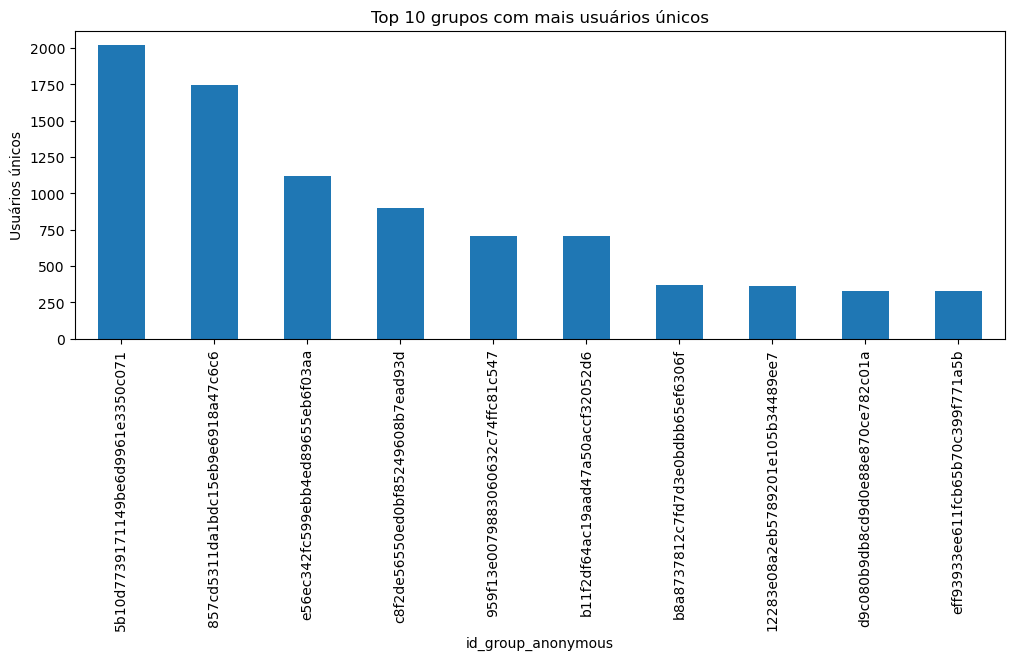

In [34]:
usuarios_por_grupo = df.groupby("id_group_anonymous")["id_member_anonymous"].nunique()
usuarios_por_grupo.sort_values(ascending=False).head(10).plot(kind="bar", figsize=(12,4))
plt.title("Top 10 grupos com mais usuários únicos")
plt.ylabel("Usuários únicos")
plt.show()

### Detecção e caracterização de **Ataques de Flooding**

Para identificar possíveis ataques de flooding, analisamos **quantas mensagens cada usuário envia em um curto intervalo de tempo**. A ideia é detectar quando alguém começa a mandar mensagens rápido demais, o que pode atrapalhar ou travar o grupo.

A estratégia utilizada é:

1. Para cada usuário dentro de cada grupo, contamos quantas mensagens ele enviou nos últimos:
   - **1 minuto**
   - **5 minutos**
2. Se o usuário enviar:
   - **10 ou mais mensagens em 1 minuto**, ou  
   - **20 ou mais mensagens em 5 minutos**,  
   
   ele é marcado como suspeito de flooding.

Essa técnica usa uma **janela de tempo deslizante (sliding window)** e permite identificar rapidamente comportamentos anormais de envio excessivo de mensagens.


In [ ]:
import pandas as pd
import numpy as np

# Garantir que a coluna é datetime
df['date_message'] = pd.to_datetime(df['date_message'])

# Ordenar por tempo
df_sorted = df.sort_values("date_message").reset_index(drop=True)

# Criar colunas vazias
df_sorted["1min_count"] = 0
df_sorted["5min_count"] = 0

# Para cada usuário + grupo calcular janelas temporais
for (user, group), sub in df_sorted.groupby(["id_member_anonymous", "id_group_anonymous"]):
    idx = sub.index
    times = sub["date_message"].values

    # Converter timestamps para números
    ts = sub["date_message"].astype(np.int64).values

    # 1 minuto = 60s
    janela_1min = 60 * 1e9  # nanos
    janela_5min = 300 * 1e9

    # Para cada mensagem achar quantas caem na janela
    for i in range(len(ts)):
        # limite inferior da janela
        ini_1 = ts[i] - janela_1min
        ini_5 = ts[i] - janela_5min

        # contar quantos timestamps estão dentro das janelas
        count_1 = np.searchsorted(ts, ts[i]) - np.searchsorted(ts, ini_1)
        count_5 = np.searchsorted(ts, ts[i]) - np.searchsorted(ts, ini_5)

        df_sorted.loc[idx[i], "1min_count"] = count_1
        df_sorted.loc[idx[i], "5min_count"] = count_5

# Detectar Flooding
flooding = df_sorted[
    (df_sorted["1min_count"] >= 10) |
    (df_sorted["5min_count"] >= 20)
]

print("Suspeitos de Flooding:")
suspeitos = flooding[["id_member_anonymous", "id_group_anonymous"]].drop_duplicates()
suspeitos

Suspeitos de Flooding:


,id_member_anonymous,id_group_anonymous
364,abe534d581ec6d552243d6955d3c3cd8,4c6519d965020abc048521dfa837b9bb
2451,c71c8ec39a207fdfe3737ca3a4d4f5a1,857cd5311da1bdc15eb9e6918a47c6c6
2685,9b34f45b5f8af4c37ba9ec1ebe2e3606,e749f45b0eb99053f52dc14a3aa79748
5937,1665e22b0f564cd46d343f7677014821,12283e08a2eb5789201e105b34489ee7
5959,1665e22b0f564cd46d343f7677014821,959f13e0079883060632c74ffc81c547
...,...,...
275598,700a3a6db910f908e89398086b9b0fff,5b10d7739171149be6d9961e3350c071
284021,2ba46a47d0589ca30f4e08d55ac191b3,c773db3b22b0534dc28c44f0f8a721ca
284822,10c2fb00b3e64fa51c0e5cdb246a1ed3,eff93933ee611fcb65b70c399f771a5b
295017,f8cfdd1c4d35d23a5a76ca1d8a0e1294,60bc602dd52f3be65e8ecd436a178573


In [48]:
print("Quantidade de ocorrências de flooding detectadas:", len(flooding))

num_suspeitos = suspeitos["id_member_anonymous"].nunique()
print("Quantidade de usuários suspeitos:", num_suspeitos)

num_grupos_afetados = suspeitos["id_group_anonymous"].nunique()
print("Quantidade de grupos com ocorrências de flooding:", num_grupos_afetados)

Quantidade de ocorrências de flooding detectadas: 2277
Quantidade de usuários suspeitos: 53
Quantidade de grupos com ocorrências de flooding: 26


- No gráfico abaixo cada ponto roxo representa um momento em que a quantidade de mensagens ultrapassou o limite definido. O eixo Y mostra quantas mensagens ocorreram naquele período de tempo, e o eixo X mostra quando aconteceu.

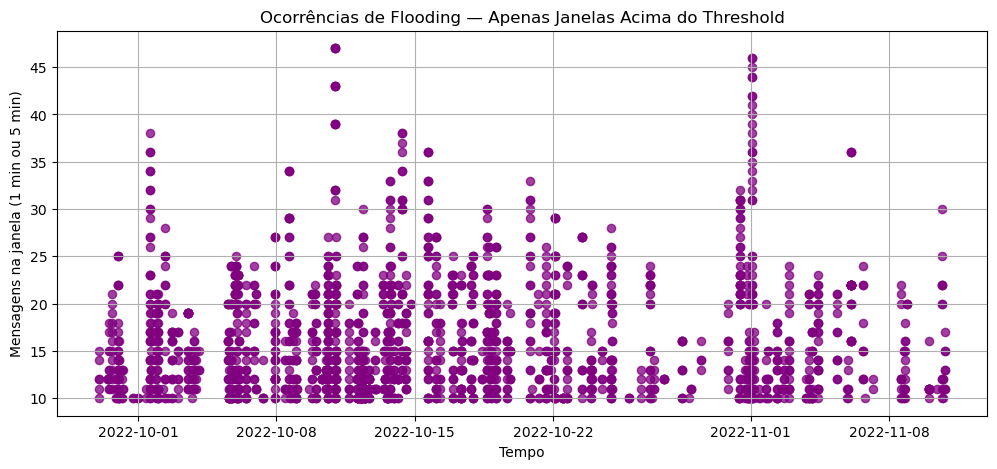

In [41]:
import matplotlib.pyplot as plt

# Seleciona apenas os pontos que ultrapassaram o threshold
df_flood_vis = df_sorted[
    (df_sorted["1min_count"] >= 10) |
    (df_sorted["5min_count"] >= 20)
].copy()

# Define qual janela foi responsável pela detecção
df_flood_vis["janela_utilizada"] = df_flood_vis.apply(
    lambda row: row["1min_count"] if row["1min_count"] >= 10 else row["5min_count"],
    axis=1
)

plt.figure(figsize=(12,5))
plt.scatter(
    df_flood_vis["date_message"],
    df_flood_vis["janela_utilizada"],
    s=35,
    color="purple",
    alpha=0.75
)

plt.title("Ocorrências de Flooding — Apenas Janelas Acima do Threshold")
plt.xlabel("Tempo")
plt.ylabel("Mensagens na janela (1 min ou 5 min)")
plt.grid(True)
plt.show()

- O gráfico abaixo mostra o comportamento de um usuário suspeito selecionado aleatoriamente. Ele apresenta quantas mensagens esse usuário enviou dentro da janela de 1 minuto no grupo onde o possível flooding foi identificado.

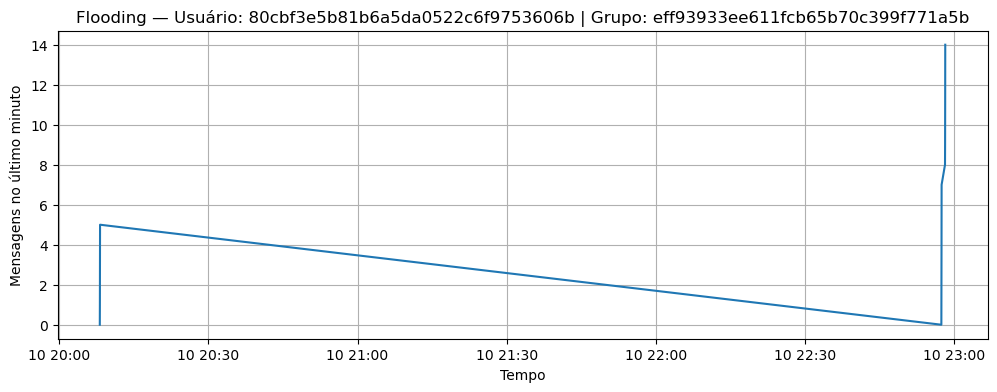

In [71]:
# Seleciona um suspeito aleatório da lista
sus = suspeitos.sample(1).iloc[0]

user = sus['id_member_anonymous']
group = sus['id_group_anonymous']

df_user = df_sorted[
    (df_sorted['id_member_anonymous'] == user) &
    (df_sorted['id_group_anonymous'] == group)
]

plt.figure(figsize=(12,4))
plt.plot(df_user['date_message'], df_user['1min_count'])

plt.title(f"Flooding — Usuário: {user} | Grupo: {group}")
plt.ylabel("Mensagens no último minuto")
plt.xlabel("Tempo")
plt.grid(True)
plt.show()

### Detecção e caracterização de **Ataques de Sequestro de Grupos**

Para detectar sequestros de grupos, foram usadas duas técnicas: uma **identifica quando um único usuário passa a dominar as mensagens** e outra **detecta quedas bruscas na atividade do grupo**. Assim, é possível identificar tanto sequestros ativos quanto silenciosos.

#### 📝 Detecção de Sequestro por Dominância Recente

Nesta técnica, analisamos apenas um período recente (ex.: últimos 7 dias) para verificar se **um único usuário passou a enviar a maior parte das mensagens do grupo**.

Se alguém concentra mais de 80% das mensagens nessa janela, isso indica que o grupo pode ter sido sequestrado, já que um invasor ou bot normalmente assume o controle de forma repentina e reduz a participação dos demais membros.

In [58]:
import pandas as pd

# Converter data
df['date_message'] = pd.to_datetime(df['date_message'])

# Definir janela (ex: últimos 7 dias)
janela = 7  # dias
cut = df['date_message'].max() - pd.Timedelta(days=janela)

df_recent = df[df['date_message'] >= cut]

# Contagem por usuário dentro da janela
contagem = (
    df_recent.groupby(["id_group_anonymous", "id_member_anonymous"])
             .size()
             .reset_index(name="msg_count")
)

# Total por grupo na janela
total_por_grupo = (
    df_recent.groupby("id_group_anonymous")
             .size()
             .reset_index(name="total_msgs")
)

# Merge
df_dom = contagem.merge(total_por_grupo, on="id_group_anonymous")

# Percentual de dominância
df_dom["percentual"] = (df_dom["msg_count"] / df_dom["total_msgs"]) * 100

# Critério: usuário domina >80% das mensagens NA JANELA
dominancia = df_dom[df_dom["percentual"] >= 80]

print("===== POSSÍVEIS SEQUESTROS (Dominância Recente) =====")
dominancia

===== POSSÍVEIS SEQUESTROS (Dominância Recente) =====


,id_group_anonymous,id_member_anonymous,msg_count,total_msgs,percentual
0,0e75a3640301db4e5063c10fbe021d43,db48cd9641d5886e1b59f97536668fca,65,65,100.000000
1,2c92eba8c92fbacc26b69c4c016e5147,bb1fa1f3e0f9cfc9cda9e90718a243cc,90,90,100.000000
114,36eb239854880a02283e5c7717db1bb7,0882715c302126d021fcef90a33f7f47,21,21,100.000000
229,5ad86f3e625f10c287582e726e6b9508,11b67816657b860a3a325f368ab21321,17,17,100.000000
837,612887149dc089cab02a05f279e8758d,6b64d4d87635ab35b4a4419977d14e06,5,5,100.000000
840,642d033a7accc561ae31b6af680e215a,c0722b378c5c84a291eacee8261eff7e,28,28,100.000000
844,79b8cc25c1b9670573f2148ec6d3066b,f4561a21fb26cfbebf48dcd5c557f82f,106,106,100.000000
845,7b881a0281c00185ff095012fbeb8001,1665e22b0f564cd46d343f7677014821,85,102,83.333333
848,7db8149e17b8ddcd4259c03fef7872d0,51ab6b2a060bf0817c4727118e6feefe,62,62,100.000000
989,aa2036d316e42e59d1b0a4ef105b2b66,e5e3e38d433016adf62ea34432853a3c,96,99,96.969697


#### 📝 Detecção de Sequestro por Queda Brusca de Atividade

Nesta técnica, comparamos a quantidade de mensagens do grupo em duas janelas de tempo iguais (por exemplo, os últimos 14 dias e os 14 dias anteriores).

Se um grupo apresenta **queda acentuada de atividade**, especialmente quando a quantidade recente cai para **zero**, isso pode indicar um **sequestro silencioso**, no qual membros são impedidos de falar ou o grupo é bloqueado por um invasor.

Essa abordagem ajuda a identificar situações em que o grupo deixa de funcionar repentinamente, um comportamento típico de ataques que restringem a participação dos usuários.

- Mostro abaixo os grupos que tiveram queda significativa na atividade (>= 70%).

In [73]:
import pandas as pd 

df["timestamp"] = pd.to_datetime(df["date_system"])

# Janela de 14 dias
cut = df["timestamp"].max() - pd.Timedelta(days=14)

recent = df[df["timestamp"] >= cut]
previous = df[(df["timestamp"] < cut) & (df["timestamp"] >= cut - pd.Timedelta(days=14))]

# Contagem por grupo
recent_count = recent.groupby("id_group_anonymous").size()
previous_count = previous.groupby("id_group_anonymous").size()

# Tabela de comparação
comparacao = pd.DataFrame({
    "anterior": previous_count,
    "recente": recent_count
}).fillna(0)

# Evitar divisão por zero
comparacao = comparacao[comparacao["anterior"] > 0].copy()

# Queda percentual
comparacao["pct_queda"] = ((comparacao["anterior"] - comparacao["recente"]) / comparacao["anterior"]) * 100

# Filtra quedas significativas (ex: >= 70%)
comparacao["queda_forte"] = comparacao["pct_queda"] >= 70

print("===== GRUPOS COM QUEDA SIGNIFICATIVA (Possível sequestro) =====")
comparacao[comparacao["queda_forte"] == True]

===== GRUPOS COM QUEDA SIGNIFICATIVA (Possível sequestro) =====


,anterior,recente,pct_queda,queda_forte
id_group_anonymous,,,,
03797305d2cd8e308ea14948be79ee40,41.0,0.0,100.000000,True
05b77e9bb9d30f454373e444a7456d98,45.0,6.0,86.666667,True
07ba9b006501f68651d80b17cbc6e4ee,146.0,43.0,70.547945,True
0c4df1733c80398d3480b27af2e38c60,98.0,7.0,92.857143,True
0e557b96b9d9e7897d22ceb28893d044,329.0,27.0,91.793313,True
12283e08a2eb5789201e105b34489ee7,3583.0,284.0,92.073681,True
1aa7e0239337451e23de97e3e003ec77,27.0,0.0,100.000000,True
1cf9e56465ddb9766a23a7da49fecb48,94.0,13.0,86.170213,True
1e01e41452279fd13939acd88a43b6eb,12.0,3.0,75.000000,True


- Aqui seleciono os grupos cuja atividade recente caiu para zero, o que pode indicar bloqueio ou silenciamento.

In [75]:
desaparecidos = comparacao[
    (comparacao["recente"] == 0)  # atividade morreu
]

print("===== GRUPOS POSSIVELMENTE SILENCIADOS / BLOQUEADOS =====")
desaparecidos

===== GRUPOS POSSIVELMENTE SILENCIADOS / BLOQUEADOS =====


,anterior,recente,pct_queda,queda_forte
id_group_anonymous,,,,
03797305d2cd8e308ea14948be79ee40,41.0,0.0,100.0,True
1aa7e0239337451e23de97e3e003ec77,27.0,0.0,100.0,True
257a0116bc6cb39fe8091432b2a0d858,1.0,0.0,100.0,True
29884dbcb227966542a700b7638fc216,4.0,0.0,100.0,True
2c7778b4efb851b065c71b3066fccb37,13.0,0.0,100.0,True
2f26d9ff7d572a9d0feada8b0bd00aae,1.0,0.0,100.0,True
385f52792ba1a1424393c1eca20c0b76,285.0,0.0,100.0,True
3a7be4d8485e23cb29a92cf597a01bb4,499.0,0.0,100.0,True
3d7f9b22d7ad642d216fc93eec598eba,158.0,0.0,100.0,True


Abaixo estão os gráficos da atividade semanal dos grupos. Aqui são exibidos os dois primeiros grupos que tiveram queda brusca nas mensagens, permitindo visualizar quando a atividade parou de repente.

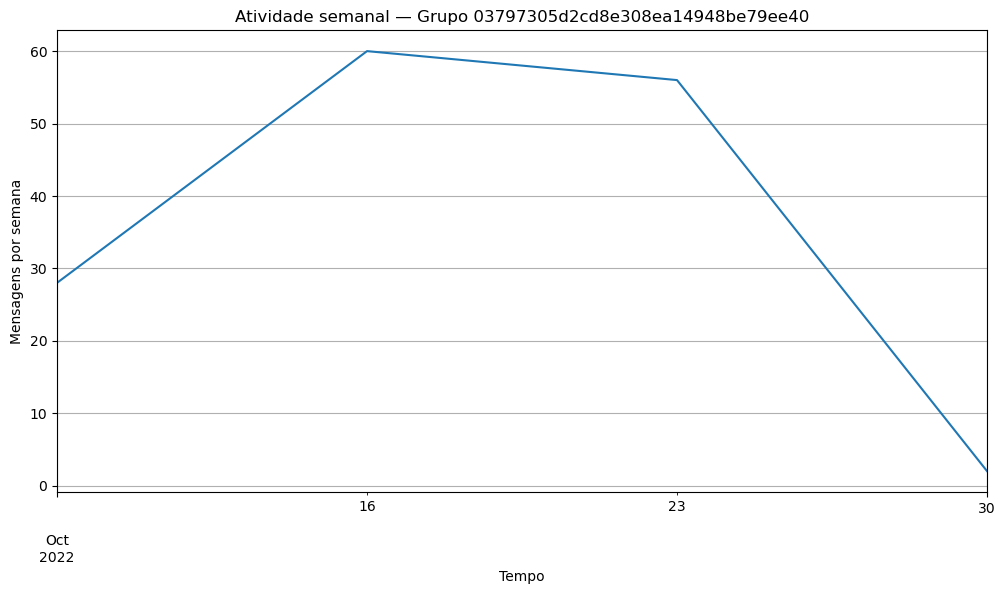

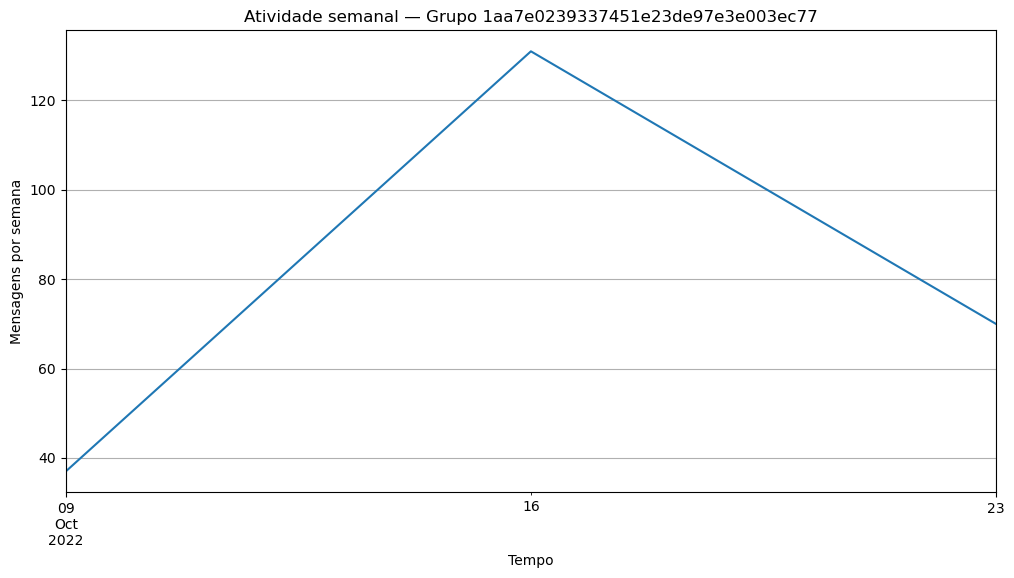

In [81]:
import matplotlib.pyplot as plt

def plot_hist_grupo(id_group):
    df_grupo = df[df["id_group_anonymous"] == id_group].copy()
    df_grupo = df_grupo.sort_values("timestamp")

    serie = (
        df_grupo.set_index("timestamp")
                .resample("1W")
                .size()
    )
    
    plt.figure(figsize=(12,6))
    serie.plot()
    plt.title(f"Atividade semanal — Grupo {id_group}")
    plt.xlabel("Tempo")
    plt.ylabel("Mensagens por semana")
    plt.grid(True)
    plt.show()

grupos_para_plot = desaparecidos.index[:2]

for grupo in grupos_para_plot:
    plot_hist_grupo(grupo)